# Analyzing Meridians Artblocks

## Get the meridians

In [1]:
import requests
from helpers import *
from IPython.display import display

OPENSEA_URL = "https://api.opensea.io/api/v1/assets"
MERIDIAN_IDS = list(range(163000000, 163001000))


def get_meridians():
    querystring = {
        "asset_contract_address": "0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270",
    }
    assets = []
    for token_ids in chunks(MERIDIAN_IDS, 20):
        print(".", end="")
        querystring["token_ids"] = token_ids
        response = requests.request("GET", OPENSEA_URL, params=querystring)
        response.raise_for_status()
        assets.extend(response.json()["assets"])
    print(f" -- All {len(assets)} assets retrieved.")
    return assets

# FIXME Turn into a generator?

meridians = get_meridians()

.................................................. -- All 1000 assets retrieved.


## Build a dataframe

In [53]:
import pandas as pd
import numpy as np
from functools import reduce
import operator

pd.set_option("display.max_rows", None)

traits = [
    "Chromaticity",
    "Frequency",
    "Palette",
    "Structure",
    "Style",
    "Zoom",
]

_tt = []
for m in meridians:
    prob_score = (
        reduce(operator.mul, [t["trait_count"] / 1000 for t in m["traits"]], 1) * 1000
    )
    price = np.nan
    if m["sell_orders"] is not None:
        so = m["sell_orders"][0]
        price = float(so["current_price"]) / 10 ** int(
            so["payment_token_contract"]["decimals"]
        )
        # FIXME Also get the currency's name
    last_price = np.nan
    if m["last_sale"] is not None:
        ls = m["last_sale"]
        last_price = float(ls["total_price"]) / 10 ** int(
            ls["payment_token"]["decimals"]
        )

    _tt.append(
        [
            m["name"].split("#")[1],
            m["name"],
            price,
            last_price,
            prob_score,
            *[  # All the traits:
                t["value"].split(":")[1]
                for t in sorted(m["traits"], key=lambda x: x["value"])
                if ":" in t["value"]
            ],
            m["permalink"],
        ]
    )


df = pd.DataFrame(_tt)
df.columns = [
    "ID",
    "Name",
    "Price",
    "Lastprice",
    "Probscore",
    *traits,
    "Link",
]
df = df.set_index("ID").sort_values("Lastprice", ascending=False)


## How many pieces have a last price on OpenSea?

In [117]:
print(f"{df[~df.Lastprice.isna()].shape[0] / df.shape[0]:.0%}")


78%


## How frequent are the different traits?

In [89]:
for trait in traits:
    display(
        pd.DataFrame(df[trait].value_counts(normalize=False, sort=True, ascending=True)).transpose()
    )


,Monochrome,Trichrome,Polychrome,Duochrome
Chromaticity,127,226,295,352


,High,Gradual,Low,Standard
Frequency,57,213,239,491


,Glacier,Cave,Mesa,Shore,Prairie,Marsh,Ridge,Delta,Atoll,Volcano,Esker,Gulf,Canyon,Archipelago,Peninsula,Reef,Dune,Cove,Fjord,Moraine,Oasis,Other
Palette,14,15,15,17,17,17,18,18,19,19,19,19,21,21,21,22,22,23,25,26,27,585


,Variable,Uniform
Structure,192,808


,Prime,Topographic,Charcoal,Newsprint,Invert,Lino,Screenprint,Watercolour,Gilded,Polarized,Procedural,Gouache,Prismatic,Paletted
Style,8,8,9,12,13,20,21,22,27,32,60,99,262,407


,Far,Medium,Close
Zoom,326,327,347


## How much do people pay for the different traits?

Note that the charts are interactive. You can zoom, hover, pan, etc.

In [166]:
import plotly.express as px
import plotly.graph_objects as go

# import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams["figure.figsize"] = (20, 10)
pd.set_option("display.max_columns", None)
pd.plotting.register_matplotlib_converters()

# sns.boxplot(x=df.Style, y=df.Lastprice, hue=df.Chromaticity)
for trait in traits:
    # sns.boxplot(x=df[trait], y=df.Lastprice).set_title(trait)
    # fig = px.box(df, x=trait, y="Lastprice", title=trait, points="all")
    # fig.show()

    fig = go.Figure()
    for traitvariant in df.groupby(trait).median().sort_values("Lastprice", ascending=False).index:
        fig.add_trace(
            go.Box(
                y=df[df[trait] == traitvariant].Lastprice.values,
                name=traitvariant,
                boxpoints="all",
                jitter=0.2,
                whiskerwidth=0.2,
                marker_size=2,
                line_width=1,
            )
        )
    fig.update_layout(title=trait)
    fig.show()


**Some observations:**

* Chromaticity: Highest prices for monochrome, approx. same level for duochrome and trichrome, lowest prices for polychrome.
* Frequency: No clear tendencies. Low seems to be clearly performing worst in terms of price; the other three are similar, on a slightly higher level.
* Palette: High variance and low sample size, therefore no clear tendencies. Peninsula seems to be performing somewhat consistently better than for example Esker or Dune.
* Structure: Irrelevant wrt to price level.
* Style: The most seldom styles obviously have the largest variance, and they also command the highest prices. Huge variance and outliers for Charcoal and Prime. Prismatic the style with consistently lowest prices.
* Zoom: Not much differentiation.

Overall, **Style** has the biggest impact on price, with additional impact added by **Chromaticity** and **Palette**. The other traits (Frequency, Structure, Zoom) don't make a lot of a difference.


## Digging deeper into Palette and Chromaticity traits

Digging deeper into Palette, we find that the only traits that use the different palettes are Paletted and Prime. Thus, for most Styles, the Palette is irrelevant because there is only one:

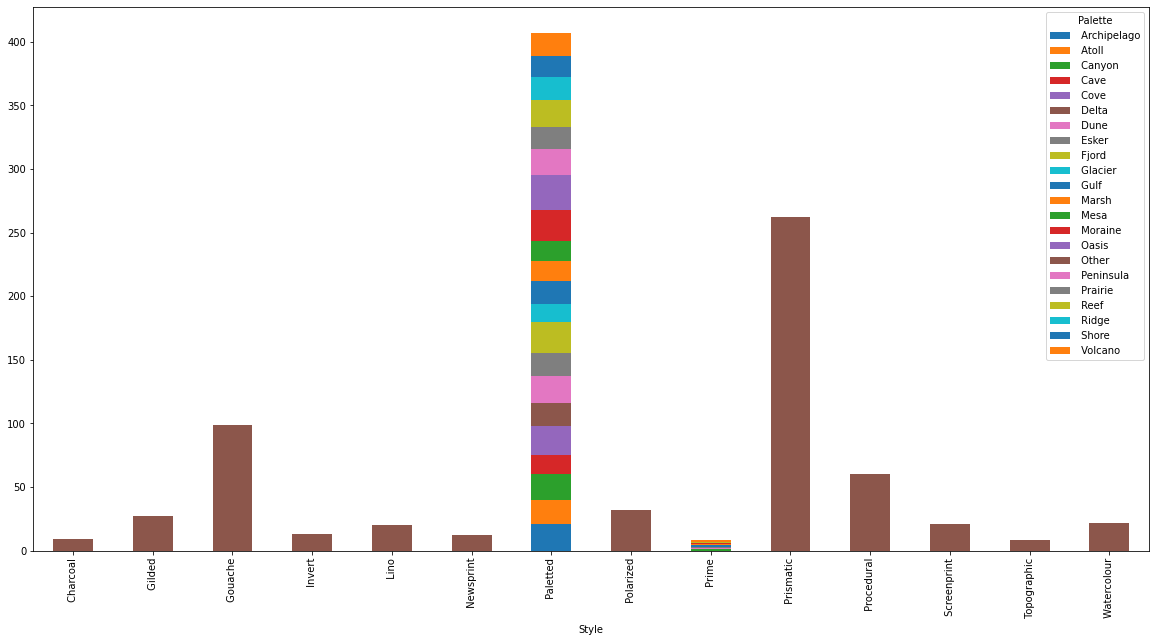

In [174]:
_ = pd.crosstab(df.Style, df.Palette).plot(kind="bar", stacked=True)

The situation is similar, albeit a bit more nuanced with the Chromaticity trait. Many styles, espcially the seldom onces, only have one type of Chromaticity, Monochrome:

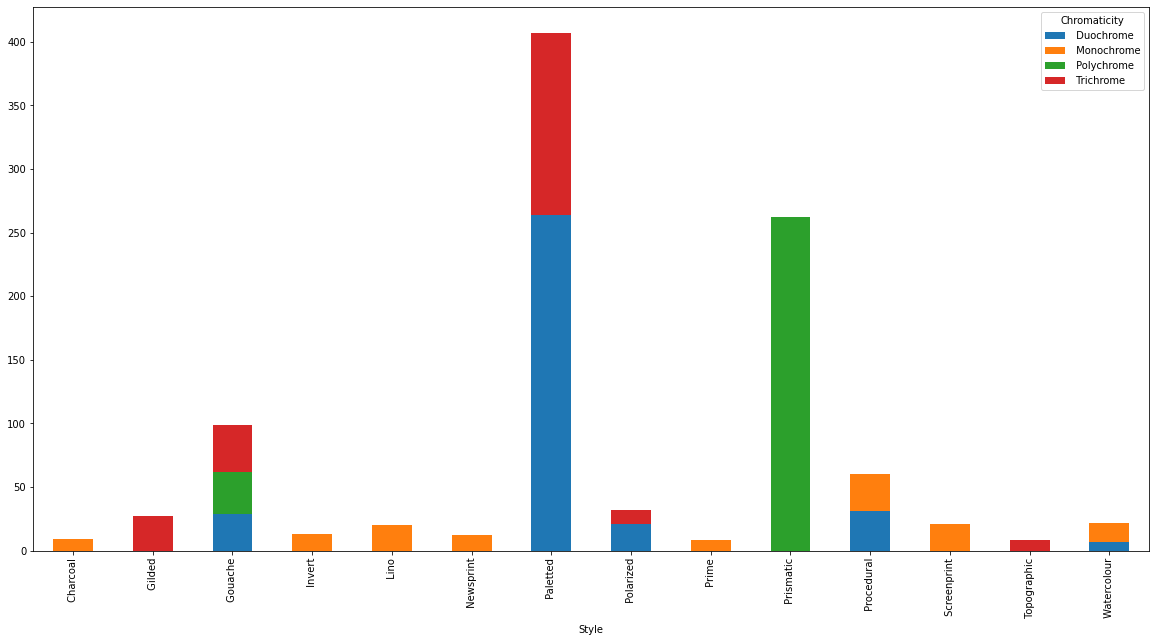

In [175]:
_ = pd.crosstab(df.Style, df.Chromaticity).plot(kind="bar", stacked=True)

In [176]:
import plotly.express as px
fig = px.box(df, x="Style", y="Lastprice", color="Chromaticity")
fig.show()


In [155]:
import plotly.graph_objects as go

fig = go.Figure()
for style in df["Style"].unique():
    fig.add_trace(
        go.Box(
            y=df[df.Style == style].Lastprice.values,
            name=style,
            boxpoints="all",
            jitter=0.2,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1,
        )
    )
fig.show()
